<img src='https://github.com/LinkedEarth/Logos/blob/master/Pyleoclim/PYLEOCLIM_logo_HORZ-01.png?raw=true' width="800">


# Tracing Transformations

by [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751)

In can be sometimes difficult to remember all the transformations that you apply to your data in the course of your work. Quite often , this results in reported protocols that do not match the actual steps taken during an analysis, so published results may not be readily reproduced. We illustrate this using the example from the [spectral analysis tutorial](L2_spectral_analysis.md).

### Goals

Learn how to use the `keep_log` parameter to keep track of all transformations applied to the timeseries

**Reading Time**: 10 minutes

### Keywords

Provenance

### Pre-Requisites

This notebook re-uses the analysis performed in [spectral analysis tutorial](L2_spectral_analysis.md). A grasp of this tutorial is necessary.

### Relevant Packages¶

Pyleoclim

## Data Description

* Lisiecki, L. E., and Raymo, M. E. (2005), A Pliocene-Pleistocene stack of 57 globally distributed benthic δ18O records, Paleoceanography, 20, PA1003, [doi:10.1029/2004PA001071](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004PA001071).

## Demonstration

In [1]:
%load_ext watermark

import pyleoclim as pyleo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's first import the LR04 benthic stack into a [`Series` object](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#series-pyleoclim-series):

In [2]:
lr04 = pyleo.utils.load_dataset('LR04')

In `L2_spectral_analysis.ipynb`, we plot this iconic compilation by inverting the y axis:

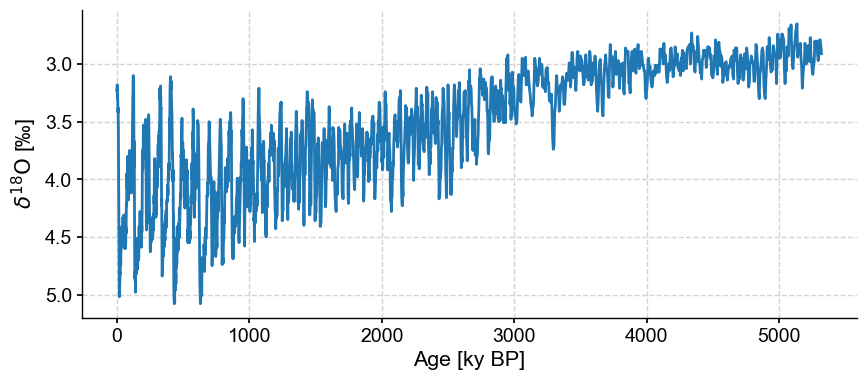

In [3]:
fig, ax = lr04.plot(legend=False, invert_yaxis=True) 

Let's work with the first 3 million years (3000 kyr) of the record for illustrative purposes:

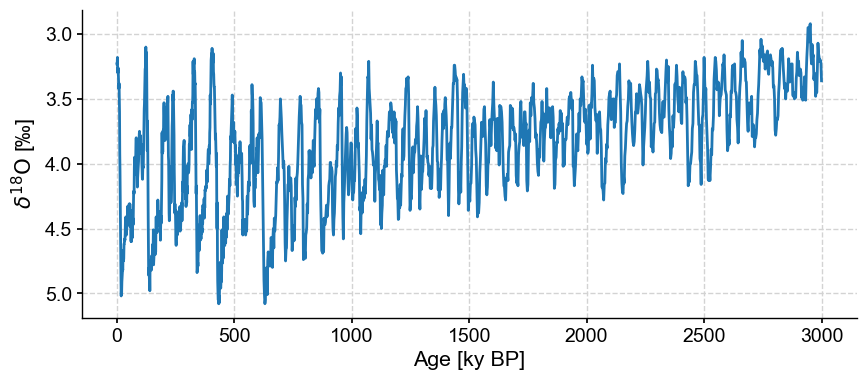

In [4]:
lr04_s = lr04.slice([0,3000])
fig,ax = lr04_s.plot(legend=False, invert_yaxis=True) 

In `L2_spectral_analysis.ipynb`, we applied 3 transformations to the data prior to conducting spectral analysis: __detrending__, __interpolation__ (each with default value), and __standardization__. If we ask to keep a log of such transformations at each turn, the resulting Series object will contain a field called `log`, which can be mined for information:

In [5]:
lr04_seq = lr04_s.detrend(keep_log=True).interp(keep_log=True).standardize(keep_log=True)

In [6]:
lr04_seq.log

({0: 'detrend',
  'method': 'emd',
  'args': {},
  'previous_trend': array([4.11436493, 4.11437622, 4.11438901, ..., 3.62013935, 3.62016692,
         3.62019564])},
 {1: 'interp', 'method': 'linear', 'args': {}},
 {2: 'standardize',
  'args': 1,
  'previous_mean': -0.03990010536672826,
  'previous_std': 0.3316320197708689})

This log is a [tuple](https://www.dataquest.io/blog/python-tuples/) of [dictionaries](https://www.dataquest.io/blog/data-structures-in-python/), a very flexible (and immutable) data structures that ensures that many fields can be traced, in an order that cannot be touched. This log reveals several things:
- the series was [cleaned](https://pyleoclim-util.readthedocs.io/en/master/utils/introduction.html#pyleoclim.utils.tsbase.clean_ts) upon creation, as is the [default](https://pyleoclim-util.readthedocs.io/en/master/utils/introduction.html#pyleoclim.utils.tsbase.clean_ts). 
- the series was then detrended, and we see here that it was done using empirical mode decomposition (see [here](https://pyleoclim-util.readthedocs.io/en/master/utils/introduction.html#pyleoclim.utils.tsutils.detrend) for details. The original trend is kept here as an array in case you need to use it later (e.g. put it back). 
- the `Series` was then interpolated using linear interpolation with default parameters.
- then it was standardized, and the log kept the mean and standard deviation in case they are needed later. 

If you wanted to access the original trend, you would go for the second index of this tuple, and use the dictionary key 'previous_trend':

In [7]:
lr04_seq.log[0]['previous_trend']

array([4.11436493, 4.11437622, 4.11438901, ..., 3.62013935, 3.62016692,
       3.62019564])

This can be plotted along side the original series:

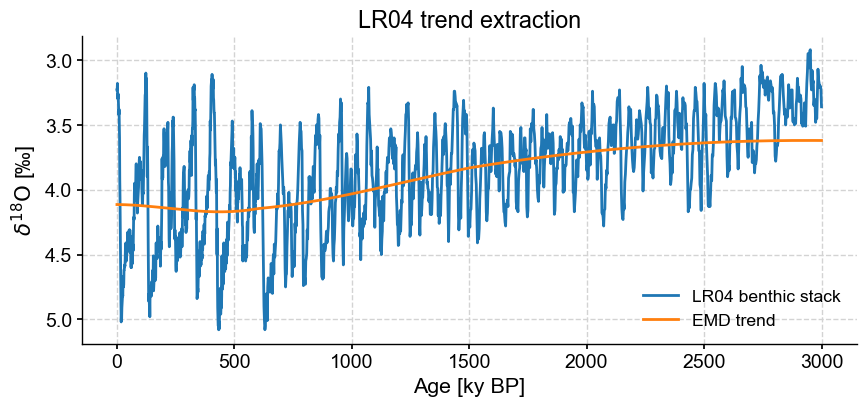

In [8]:
fig, ax = lr04_s.plot(title='LR04 trend extraction', invert_yaxis=True)
ax.plot(lr04_s.time,lr04_seq.log[0]['previous_trend'],label='EMD trend')
ax.legend(); 

So far we have worked with the original, but flipped the plots. We may instead wish to flip the values themselves:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ky BP]', ylabel='$\\delta^{18} \\mathrm{O}$ x (-1) [‰]'>)

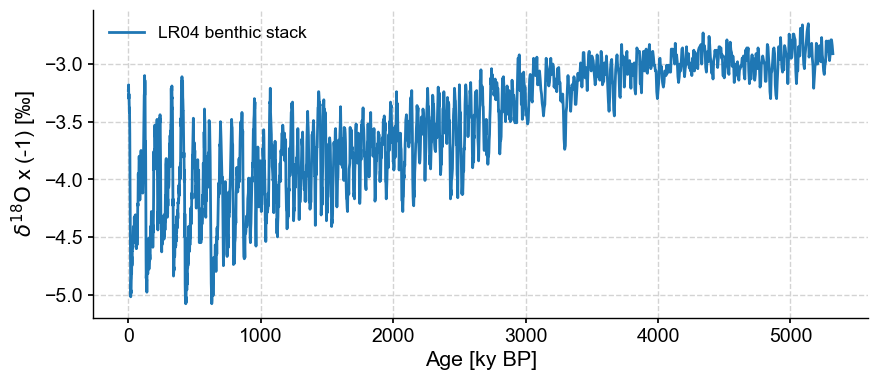

In [9]:
lr04_f = lr04.flip(axis='value', keep_log=True)
lr04_f.plot()

Note that the label has been updated to reflect the flip. If we now apply the same sequence of transformations as before, this will be reflected in the log:

In [10]:
lr04_fseq = lr04_f.detrend(keep_log=True).interp(keep_log=True).standardize(keep_log=True)
lr04_fseq.log

({0: 'flip', 'applied': True, 'axis': 'value'},
 {1: 'detrend',
  'method': 'emd',
  'args': {},
  'previous_trend': array([-4.11361122, -4.11359379, -4.11357686, ..., -2.92825926,
         -2.92825817, -2.92826008])},
 {2: 'interp', 'method': 'linear', 'args': {}},
 {3: 'standardize',
  'args': 1,
  'previous_mean': 0.000358900643691679,
  'previous_std': 0.25330907793231616})

The Series can be flipped back, but an error message will be issued to warn users that flipping was previously applied:

In [11]:
lr04_ff = lr04_fseq.flip(keep_log=True)

/Users/julieneg/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:764: UserWarning: this Series' log indicates that it has previously been flipped
  warnings.warn("this Series' log indicates that it has previously been flipped")


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ky BP]', ylabel='$\\delta^{18} \\mathrm{O}$ x (-1) x (-1) [‰]'>)

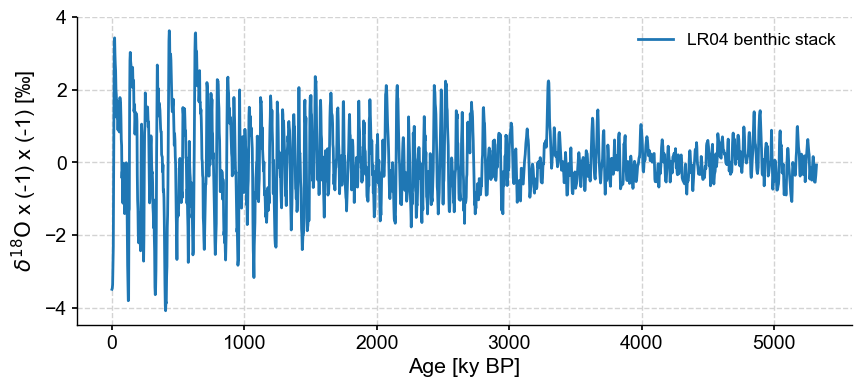

In [12]:
lr04_ff.plot()

In this case, one might want to clean up the `value_name` property, by copying the original one:

In [13]:
lr04_ff.value_name = lr04.value_name

Finally, the log will reflect this double-flipping as well:

In [14]:
lr04_ff.log

({0: 'flip', 'applied': True, 'axis': 'value'},
 {1: 'detrend',
  'method': 'emd',
  'args': {},
  'previous_trend': array([-4.11361122, -4.11359379, -4.11357686, ..., -2.92825926,
         -2.92825817, -2.92826008])},
 {2: 'interp', 'method': 'linear', 'args': {}},
 {3: 'standardize',
  'args': 1,
  'previous_mean': 0.000358900643691679,
  'previous_std': 0.25330907793231616},
 {4: 'flip', 'applied': True, 'axis': 'value'})

In [2]:
%watermark -n -u -v -iv -w

Last updated: Mon Mar 04 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

pyleoclim : 0.13.1b0
numpy     : 1.26.3
matplotlib: 3.8.2
pandas    : 2.1.4

Watermark: 2.4.3

